In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, RepeatVector, Dense, TimeDistributed, BatchNormalization
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras import backend as K

import datetime
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
import gc

In [2]:
data_path = '/content/drive/My Drive/Colab Notebooks/data/'
model_path = '/content/drive/My Drive/Colab Notebooks/Cuba Temperature/Model/'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
df = pd.read_csv(data_path+'cuba_temperature.csv')
df[-20:]

,dt,AverageTemperature
2269,2012-02-01,24.418
2270,2012-03-01,24.904
2271,2012-04-01,25.255
2272,2012-05-01,26.542
2273,2012-06-01,27.778
2274,2012-07-01,28.026
2275,2012-08-01,28.301
2276,2012-09-01,27.983
2277,2012-10-01,26.954
2278,2012-11-01,24.587


## Preprocessing

### Combine 'Date' and 'hour' to form datetime

In [5]:
df['dt'] = pd.to_datetime(df['dt'])
dt_var = 'dt'
target_var = 'AverageTemperature'
df = df[[dt_var,target_var]]
df.dtypes

dt                    datetime64[ns]
AverageTemperature           float64
dtype: object

### Impute missing datetime

In [6]:
def get_discontinous_idx(dt_array, interval_type):
    datetime_interval_dict = {'per minute': 'm',
                              'hourly': 'h',
                              'daily': 'D',
                              'monthly': 'M',
                              'yearly': 'Y'} 
    minuend = dt_array[1:].reset_index(drop=True)
    interval = np.round((minuend - dt_array[:-1]) / np.timedelta64(1, datetime_interval_dict[interval_type]))
    discontinuous_info = [[idx,num_discontinuous] for idx,num_discontinuous in enumerate(interval) if num_discontinuous>1]
    return discontinuous_info

# last_index must be of type datetime
def get_missing_dt(last_index, datetime_interval, timestep):   
    datetime_interval_dict = {'per minute': 'T',
                              'hourly': 'H',
                              'daily': 'D',
                              'monthly': 'M',
                              'yearly': 'Y'}
    missing_dt = pd.period_range(last_index, freq=datetime_interval_dict[datetime_interval], periods=timestep+1).to_timestamp()[1:]
    return missing_dt 

def impute_data(df, missing_dt):    
    cols = df.columns
    df = df.append(pd.DataFrame([[missing_dt[i]]+[np.nan]*(len(cols)-1) for i in range(len(missing_dt))], columns=cols))
    return df

In [7]:
datetime_interval = 'monthly'
discontinuous_dt = get_discontinous_idx(df[dt_var], datetime_interval)
for item in discontinuous_dt:
    missing_dt = get_missing_dt(df.loc[item[0],dt_var], datetime_interval, item[1]-1)
    df = impute_data(df, missing_dt)

df = df.sort_values(dt_var).reset_index(drop=True)    
df = df.fillna(method='ffill')


In [8]:
df[-20:]

,dt,AverageTemperature
2269,2012-02-01,24.418
2270,2012-03-01,24.904
2271,2012-04-01,25.255
2272,2012-05-01,26.542
2273,2012-06-01,27.778
2274,2012-07-01,28.026
2275,2012-08-01,28.301
2276,2012-09-01,27.983
2277,2012-10-01,26.954
2278,2012-11-01,24.587


## Prepare dataset for modelling

In [9]:
def get_train_test(X, in_timestep, out_timestep, forecast_timestep=None):
    if not forecast_timestep:
        forecast_timestep = out_timestep
    num_batches = int(len(X) - out_timestep - (in_timestep-1))
    num_test_batch = forecast_timestep - out_timestep + 1
    num_train_batch = num_batches - num_test_batch
    
    train_end_idx = in_timestep + (num_train_batch-1) + out_timestep
    test_start_idx = num_train_batch - 1
    
    train = X[:train_end_idx]
    test = X[test_start_idx:]
    
    return train, test	

def reshape(X, n_features):
    X = np.asarray(X)
    try:
        return X.reshape(X.shape[0], X.shape[1], n_features)
    except:
        return X.reshape(X.shape[0], n_features)

def prepare_target_series(series, n_output):
    stacked = []
    for i in range(len(series)):
        stacked.append(series[i:n_output+i])
        
    return np.asarray(stacked)

def gen_to_list(gen):
    combined_X, combined_y = [], []
    for batch in gen:
        combined_X.append(batch[0][0])
        combined_y.append(batch[1][0])

    return np.asarray(combined_X), np.asarray(combined_y)        


In [10]:
def prepare_data(target, in_timestep, out_timestep, forecast_timestep, n_features, shuffle=False):
    train, test = get_train_test(target, in_timestep, out_timestep, forecast_timestep)
    train2, test2 = prepare_target_series(train, out_timestep), prepare_target_series(test, out_timestep)

    train = reshape(train, n_features)
    test = reshape(test, n_features)

    train2 = reshape(train2, out_timestep)
    test2 = reshape(test2, out_timestep)

    train_generator = TimeseriesGenerator(train, train2, length=in_timestep, batch_size=out_timestep, shuffle=shuffle)
    test_generator = TimeseriesGenerator(test, test2, length=in_timestep, batch_size=out_timestep, shuffle=shuffle)

    tr_valid_X, tr_valid_y = gen_to_list(train_generator)
    test_X, test_y = gen_to_list(test_generator)
    train_X, valid_X, train_y, valid_y = train_test_split(tr_valid_X, tr_valid_y, test_size=0.3, random_state=42)
    
    train_X = reshape(train_X, n_features)
    valid_X = reshape(valid_X, n_features)
    train_y = reshape(train_y, n_features)
    valid_y = reshape(valid_y, n_features)

    return train_X, valid_X, train_y, valid_y, test_X, test_y

In [11]:
def forecast(model, test_X, in_timestep, out_timestep, n_features, m_type, forecast_timestep=None):          
    yhats = []
    to_predict = test_X[0]

    for i in range(int(np.ceil([forecast_timestep/out_timestep])[0])):
        yhat = model.predict(to_predict.reshape(1,to_predict.shape[0], to_predict.shape[1]),verbose=0)[-1]
        if m_type == 'vanilla':
            yhats.append(yhat)
            to_predict = np.concatenate((to_predict, [yhat]))
        else:
            for x in yhat:
                yhats.append(x)
            to_predict = np.concatenate((to_predict, yhat))
        to_predict = np.roll(to_predict, -out_timestep, axis=0)[:in_timestep]

    yhats = np.asarray(yhats)
    # if data is univariate, transform prediction to 1d array
    if n_features == 1:
        yhats.reshape(yhats.shape[0],)
    yhats = yhats[:forecast_timestep]

    return yhats

### **EarlyStopping**

In [12]:
class EarlyStoppingByLossVal(Callback):
    """Callback to stop Keras training based on validation loss.

    """          
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0, patience=10):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose
        self.patience = patience

    def on_train_begin(self, logs={}):
        self.best = np.Inf
        self.prev = None
        self.wait = 0

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)
            
        if epoch > 1:
            if np.isnan(self.prev):
                self.stopped_epoch = epoch
                self.model.stop_training = True

            if abs(current-self.prev) < self.value:
                self.wait += 1
                if self.wait >= self.patience:
                    self.stopped_epoch = epoch                
                    if self.verbose > 0:
                        print("Epoch %05d: early stopping THR" % epoch)
                    self.model.stop_training = True
            else:
                self.wait = 0

        self.prev = current

In [13]:
class EarlyStoppingByOverfitting(Callback):
    """Callback to stop Keras training when the model is overfitting.

    """     
    def __init__(self, ratio=0.4,
                 patience=50, verbose=0):
        super(Callback, self).__init__()
        
        self.ratio = ratio
        self.patience = patience
        self.verbose = verbose
        self.min_val_loss = np.inf
        self.wait = 0
        self.stopped_epoch = 0
        self.monitor_op = np.greater

    def on_train_begin(self, logs=None):
        self.wait = 0  # Allow instances to be re-used

    def on_epoch_end(self, epoch, logs=None):
        current_val = logs.get('val_loss')
        current_train = logs.get('loss')
        if current_val is None:
            warnings.warn('Early stopping requires %s available!' %
                          (self.monitor), RuntimeWarning)

        if current_val < self.min_val_loss:
            self.min_val_loss = current_val

        # If ratio current_loss / current_val_loss > self.ratio
        if self.monitor_op(np.divide(current_train,self.min_val_loss),self.ratio):
            self.wait = 0
        else:
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
            self.wait += 1

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0 and self.verbose > 0:
            print('Epoch %05d: early stopping' % (self.stopped_epoch)) 

### Transform time series to 3d shape of (batch, timestep, n_feature)


In [14]:
const_loss_es = EarlyStoppingByLossVal(monitor='val_loss', value=0.00001, verbose=1)
overfitting_es = EarlyStoppingByOverfitting(verbose=1)

In [15]:
target = df[target_var].values
s_period = 12
n_features = 1
in_timestep = s_period
out_timestep = 1
forecast_timestep = s_period* 5


train_X, valid_X, train_y, valid_y, test_X, test_y = prepare_data(target, in_timestep, out_timestep, forecast_timestep, n_features, shuffle=False)


In [16]:
train_y = train_y.reshape(train_y.shape[0], train_y.shape[1])
valid_y = valid_y.reshape(valid_y.shape[0], valid_y.shape[1])
test_y = test_y.reshape(test_y.shape[0], test_y.shape[1])

### **Experiment 1**

In [28]:
del model, history
gc.collect()

171300

In [ ]:
start_t = datetime.datetime.now()
print('Start time: ', start_t)

checkpoint = ModelCheckpoint(model_path+"N2_1.hdf5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto')

count = 1
while True:
    print('Training no: ', count)
    K.clear_session()

    model = Sequential()
    model.add(BatchNormalization())
    model.add((LSTM(200, input_shape=(in_timestep, n_features), return_sequences=True)))
    model.add(BatchNormalization())
    model.add(LSTM(200, return_sequences=True))
    model.add(BatchNormalization())
    model.add(LSTM(200))
    model.add((Dense(n_features)))
    model.compile(optimizer='adam', loss='mse')

    history = model.fit(x=train_X, y=train_y, validation_data=(valid_X,valid_y) ,epochs=500, verbose=1, workers=-1, batch_size=20, callbacks=[checkpoint, const_loss_es, overfitting_es])
    if len(np.unique(history.history['val_loss'])) > 10 or count > 6:
        break

    del model, history
    gc.collect()
    count += 1

print("Duration: ", datetime.datetime.now() - start_t)

0.32537364959716797 0.02985357493162155


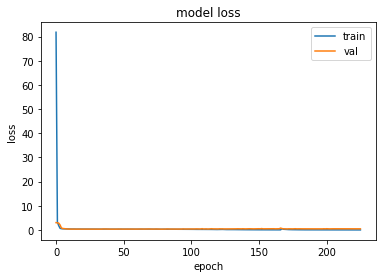

In [30]:
min_val_loss_idx = np.argmin(history.history['val_loss'])
min_loss_idx = np.argmin(history.history['loss'])
print(history.history['val_loss'][min_val_loss_idx], history.history['loss'][min_loss_idx])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

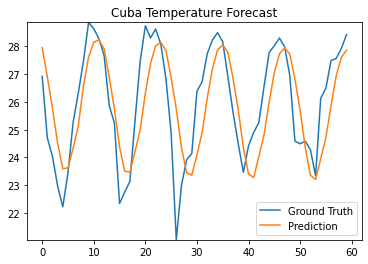

In [32]:
model.load_weights(model_path+"N2_1.hdf5")

yhats = forecast(model, test_X, in_timestep, out_timestep, n_features, m_type='vanilla', forecast_timestep=forecast_timestep)    

observed = np.asarray(target[-(forecast_timestep):])
predicted1 = np.asarray([x[0] for x in yhats])
min_y = np.min(np.concatenate([observed, predicted1]))
max_y = np.max(np.concatenate([observed, predicted1]))

figure, ax = plt.subplots(n_features,1, figsize=(6,4))
plt.plot(observed)
plt.plot(predicted1)
plt.title("Cuba Temperature Forecast")
plt.legend(['Ground Truth', 'Prediction'])
plt.ylim([min_y, max_y])
plt.show()

In [33]:
t_yhats = np.asarray([x[0] for x in yhats]).transpose()
t_target = np.asarray(target[-len(yhats):]).transpose()

min_value = np.min(t_target)
max_value = np.max(t_target)

rmse = np.sqrt(mse(t_target, t_yhats))
print('RMSE: {}'.format(rmse))

RMSE: 1.4008289832379384


### **Experiment 2**

In [19]:
del model, history
gc.collect()

12700

In [ ]:
start_t = datetime.datetime.now()
print('Start time: ', start_t)

checkpoint = ModelCheckpoint(model_path+"N2_2.hdf5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto')

count = 1
while True:
    print('Training no: ', count)
    K.clear_session()

    model = Sequential()
    model.add(BatchNormalization())
    model.add((LSTM(200, input_shape=(in_timestep, n_features), return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(LSTM(200, return_sequences=True))   
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(LSTM(200, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(LSTM(200))        
    model.add(Dropout(0.1))
    model.add((Dense(n_features)))
    model.compile(optimizer='adam', loss='mse')

    history = model.fit(x=train_X, y=train_y, validation_data=(valid_X,valid_y) ,epochs=400, verbose=1, workers=-1, batch_size=20, callbacks=[checkpoint, const_loss_es, overfitting_es])
    if len(np.unique(history.history['val_loss'])) > 10 or count > 6:
        break

    del model, history
    gc.collect()
    count += 1

print("Duration: ", datetime.datetime.now() - start_t)

388 76
0.361552894115448 0.3802720010280609


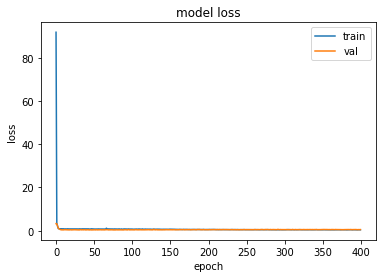

In [21]:
min_val_loss_idx = np.argmin(history.history['val_loss'])
min_loss_idx = np.argmin(history.history['loss'])
print(min_loss_idx, min_val_loss_idx)
print(history.history['val_loss'][min_val_loss_idx], history.history['loss'][min_loss_idx])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

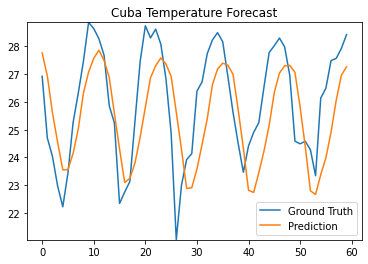

In [22]:
model.load_weights(model_path+"N2_2.hdf5")

yhats = forecast(model, test_X, in_timestep, out_timestep, n_features, m_type='vanilla', forecast_timestep=forecast_timestep)    

observed = np.asarray(target[-(forecast_timestep):])
predicted1 = np.asarray([x[0] for x in yhats])
min_y = np.min(np.concatenate([observed, predicted1]))
max_y = np.max(np.concatenate([observed, predicted1]))

figure, ax = plt.subplots(n_features,1, figsize=(6,4))
plt.plot(observed)
plt.plot(predicted1)
plt.title("Cuba Temperature Forecast")
plt.legend(['Ground Truth', 'Prediction'])
plt.ylim([min_y, max_y])
plt.show()

In [23]:
t_yhats = np.asarray([x[0] for x in yhats]).transpose()
t_target = np.asarray(target[-len(yhats):]).transpose()

min_value = np.min(t_target)
max_value = np.max(t_target)

rmse = np.sqrt(mse(t_target, t_yhats))
print('RMSE: {}'.format(rmse))

RMSE: 1.6808998952687946


### **Experiment 3**

In [24]:
del model, history
gc.collect()

3972

In [25]:
start_t = datetime.datetime.now()
print('Start time: ', start_t)

checkpoint = ModelCheckpoint(model_path+"N2_3.hdf5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='auto')

count = 1
while True:
    print('Training no: ', count)
    K.clear_session()

    model = Sequential()
    model.add(BatchNormalization())
    model.add((LSTM(300, input_shape=(in_timestep, n_features), return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(LSTM(300, return_sequences=True))   
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(LSTM(300, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(LSTM(300))        
    model.add(Dropout(0.1))
    model.add((Dense(n_features)))
    model.compile(optimizer='adam', loss='mse')

    history = model.fit(x=train_X, y=train_y, validation_data=(valid_X,valid_y) ,epochs=400, verbose=1, workers=-1, batch_size=20, callbacks=[checkpoint, const_loss_es, overfitting_es])
    if len(np.unique(history.history['val_loss'])) > 10 or count > 6:
        break

    del model, history
    gc.collect()
    count += 1

print("Duration: ", datetime.datetime.now() - start_t)

Start time:  2020-07-12 16:58:37.298759
Training no:  1
Epoch 1/400
77/78 [============================>.] - ETA: 0s - loss: 54.4440
Epoch 00001: val_loss improved from inf to 3.22888, saving model to /content/drive/My Drive/Colab Notebooks/Cuba Temperature/Model/N2_3.hdf5
78/78 [==============================] - 5s 68ms/step - loss: 54.0724 - val_loss: 3.2289
Epoch 2/400
77/78 [============================>.] - ETA: 0s - loss: 1.0516
Epoch 00002: val_loss improved from 3.22888 to 3.02426, saving model to /content/drive/My Drive/Colab Notebooks/Cuba Temperature/Model/N2_3.hdf5
78/78 [==============================] - 4s 45ms/step - loss: 1.0466 - val_loss: 3.0243
Epoch 3/400
78/78 [==============================] - ETA: 0s - loss: 0.9012
Epoch 00003: val_loss improved from 3.02426 to 1.69233, saving model to /content/drive/My Drive/Colab Notebooks/Cuba Temperature/Model/N2_3.hdf5
78/78 [==============================] - 3s 44ms/step - loss: 0.9012 - val_loss: 1.6923
Epoch 4/400
77/78 [

0.34705623984336853 0.2811644375324249


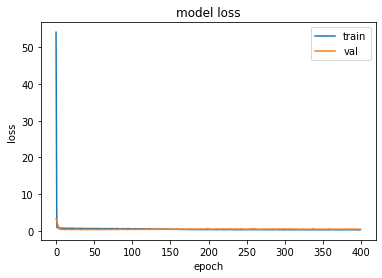

In [26]:
min_val_loss_idx = np.argmin(history.history['val_loss'])
min_loss_idx = np.argmin(history.history['loss'])
print(history.history['val_loss'][min_val_loss_idx], history.history['loss'][min_loss_idx])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

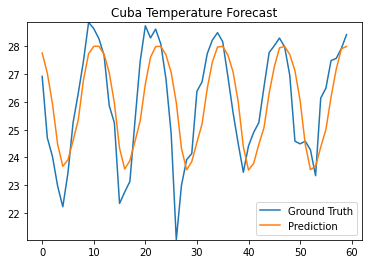

In [28]:
model.load_weights(model_path+"N2_3.hdf5")

yhats = forecast(model, test_X, in_timestep, out_timestep, n_features, m_type='vanilla', forecast_timestep=forecast_timestep)    

observed = np.asarray(target[-(forecast_timestep):])
predicted1 = np.asarray([x[0] for x in yhats])
min_y = np.min(np.concatenate([observed, predicted1]))
max_y = np.max(np.concatenate([observed, predicted1]))

figure, ax = plt.subplots(n_features,1, figsize=(6,4))
plt.plot(observed)
plt.plot(predicted1)
plt.title("Cuba Temperature Forecast")
plt.legend(['Ground Truth', 'Prediction'])
plt.ylim([min_y, max_y])
plt.show()

In [29]:
t_yhats = np.asarray([x[0] for x in yhats]).transpose()
t_target = np.asarray(target[-len(yhats):]).transpose()

min_value = np.min(t_target)
max_value = np.max(t_target)

rmse = np.sqrt(mse(t_target, t_yhats))
print('RMSE: {}'.format(rmse))

RMSE: 1.3326346082680889
